# Pairs Trading Strategy

In [1]:
# Install necessary packages
%pip install statsmodels

In [2]:
# Importing of libraries
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import yfinance as yf

## 🧺 Asset Universe Selection/Data preprocessing + cleaning


In [3]:
# Data preprocessing

def normalize_data(ticker1, ticker2, startdate, enddate):
    """
    This function cleans and normalizes the two tickers we wish to pair trade in a given timeframe. 
    The code takes logs of the price series to stabilize variance and enhance the linearity of relationships between assets. 
    This helps ensure that the regression and cointegration tests produce meaningful and stable results, rather than being skewed by raw price scales or volatility outliers.

    Argument:
    ticker1, ticker2 -- the two tickers we want to trade
    date1, date2 -- starting and ending dates of the timeframe

    Returns:
    log_data -- closing prices for the two tickers, which have been through log transformation
    
    (Optional) log_zscore_data -- closing prices for the two tickers, which have been through log transformation and normalization
    
    """
    # Log transformation on closing prices
    tickers = [ticker1, ticker2]
    data = yf.download(tickers, start=startdate, end=enddate, auto_adjust=True)
    data = data.dropna()
    log_data1 = np.log1p(data["Close"][ticker1])
    log_data2 = np.log1p(data["Close"][ticker2])
    
    # Calculating the z-scores 
    log_zscore_data1 = (log_data1-log_data1.mean())/log_data1.std()
    log_zscore_data2 = (log_data2-log_data2.mean())/log_data2.std()

    return log_data1,log_data2, data


# Example usage 
d1, d2, d3 = normalize_data('AAPL', 'MSFT', '2020-01-01', '2024-12-31')
print (d1.head())

[*********************100%***********************]  2 of 2 completed

Date
2020-01-02    4.298928
2020-01-03    4.289292
2020-01-06    4.297120
2020-01-07    4.292470
2020-01-08    4.308212
Name: AAPL, dtype: float64


## 🔍 Cointegration Testing (Engle-Granger)


In [4]:
# Cointegration Test
def test_cointegration(series_y, series_x, significance=0.05):
    """
    To test for cointegration, we first need to ensure the two price series are non stationary. This is done by ADF test.

    ADF Test:
    - Null hypothesis: Non Stationarity exists in the series.
    - Alternative Hypothesis: Stationarity exists in the series.

    Therefore to indicate non-stationarity in both time series, we seek a p-value > signficance.

    The Engle-Granger test then provides a p-value indicating whether the pair is likely cointegrated. 
    We look for a p-value below a chosen significance threshold (commonly 5%).

    Engle-Granger test:
    - Regress one series on the other
    - Find the residuals
    - Test residuals for stationarity
    
    Arguments:
    - series_y: Dependent asset (e.g., AAPL)
    - series_x: Independent asset (e.g., MSFT)
    - significance: p-value threshold for ADF test
    
    Returns:
    - is_cointegrated (bool)
    - beta_hat (float)
    - adf_pval (float)
    - spread (Series): residual spread if cointegrated, else None
    
    """

    # Test if both time series are non stationary
    pval1 = adfuller(series_x)[1]
    pval2 = adfuller(series_y)[1]
    if pval1 < significance  or pval2 < significance:
        return False, None, None, None

    #Fitting model
    model = OLS(series_y, add_constant(series_x)).fit()

    # Obtaining Residuals + beta (hedge ratio)
    resid = model.resid
    beta = model.params[1]

    # Testing residuals for stationarity
    adf_pval = adfuller(resid)[1]

    # Boolean, which indicates if the pair is cointegrated or not
    is_cointegrated = adf_pval < significance

    return is_cointegrated, beta, adf_pval, resid if is_cointegrated else None

# Example Usage
print(test_cointegration(d1,d2))

C:\Users\lovet\AppData\Local\Temp\ipykernel_456\885639854.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


(np.False_, np.float64(0.9950820107923741), np.float64(0.25237085654696356), None)


In [5]:
def find_cointegrated_pairs(log_price_df, significance=0.05):
    """
    Run cointegration tests across all unique pairs of columns in the DataFrame.

    Arguments:
    - log_price_df: DataFrame of log-transformed prices with each column as an asset
    - significance: p-value threshold to confirm cointegration (default = 0.05)

    Returns:
    - valid_pairs: list of cointegrated asset name pairs (tuple)
    - hedge_ratios: dict of (asset1, asset2) : beta
    - adf_results: dict of (asset1, asset2) : pval
    - spreads: dict of (asset1, asset2) : residual spread 
    """
    symbols = log_price_df.columns.tolist()
    pairs = [(i, j) for i in symbols for j in symbols if i < j]
    valid_pairs = []
    hedge_ratios = {}
    adf_results = {}
    spreads = {}

    for a1, a2 in pairs:
        y = log_price_df[a1]
        x = log_price_df[a2]
        is_cointegrated, beta, pval, spread = test_cointegration(y, x, significance)
        adf_results[(a1, a2)] = pval
        if is_cointegrated:
            valid_pairs.append((a1, a2))
            hedge_ratios[(a1, a2)] = beta
            spreads[(a1, a2)] = spread

    return valid_pairs, hedge_ratios, adf_results, spreads


## 📐 Spread & Z-score Calculation

In [6]:
'''
This function creates a DataFrame using (Arguments):
- tickers from the list of valid pairs from the find valid pairs function
- startdate and enddate for the time period of interest

Returns:
- A DataFrame with the following columns:
- Price_ticker1: Closing prices of the first ticker
- Price_ticker2: Closing prices of the second ticker
- Spread: Absolute difference between the two prices
- StdDev: Standard deviation of the spread over the past 20 days
- Middle_Band: 20-day moving average of the spread
- Top_Band: Middle_Band + 2 * StdDev
- Bottom_Band: Middle_Band - 2 * StdDev
'''

def calculate_values(tickers, startdate, enddate):

    # Storing the data in a DataFrame
    data = yf.download(tickers, start=startdate, end=enddate, auto_adjust=True)
    df = pd.DataFrame({
        'Price_ticker1': data['Close'][tickers[0]],
        'Price_ticker2': data['Close'][tickers[1]]
    })
    df = df.dropna()

    # Calculate Spread
    df['Spread'] = abs(df['Price_ticker1'] - df['Price_ticker2'])

    # Calculate the standard deviation of the spread over the past 20 days
    df['StdDev'] = df['Spread'].rolling(window=20).std()

    # Calculate the top, middle and bottom Bollinger Bands
    df['Middle_Band'] = df['Spread'].rolling(window=20).mean()
    df['Top_Band'] = df['Middle_Band'] + (2 * df['StdDev'])
    df['Bottom_Band'] = df['Middle_Band'] - (2 * df['StdDev'])

    return df.dropna() # Removes the 1st 20 rows with NaN values due to rolling calculations

# Using Apple and Microsoft as an example to create the DataFrame
df = calculate_values(('AAPL', 'MSFT'), '2024-01-01', '2024-12-31')

df.head(5)

[*********************100%***********************]  2 of 2 completed


,Price_ticker1,Price_ticker2,Spread,StdDev,Middle_Band,Top_Band,Bottom_Band
Date,,,,,,,
2024-01-30,186.672974,404.004059,217.331085,10.688961,198.152369,219.530292,176.774446
2024-01-31,183.059433,393.117645,210.058212,10.328218,199.534429,220.190866,178.877993
2024-02-01,185.501541,399.248016,213.746475,10.070682,201.045259,221.186623,180.903895
2024-02-02,184.498901,406.604492,222.105591,10.201278,202.989402,223.391958,182.586846
2024-02-05,186.315552,401.097015,214.781464,9.454618,204.540494,223.449730,185.631258


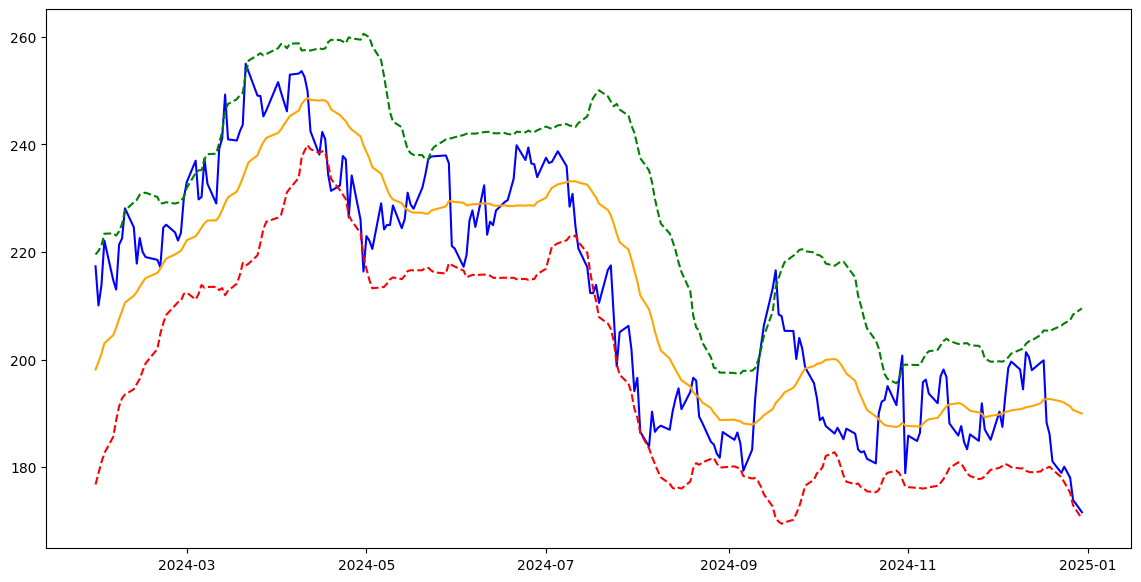

In [7]:
# Example -- Plotting the data to show the spread and Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(df['Spread'],color='blue')
plt.plot(df['Middle_Band'], color='orange')
plt.plot(df['Top_Band'], color='green', linestyle='--')
plt.plot(df['Bottom_Band'], color='red', linestyle='--')

In [8]:
# Generating Trading Signals Using Bollinger Bands
'''
This function generates trading signals based on the Bollinger Bands strategy.
It adds a 'Signal' column to the DataFrame, where:
- 1 indicates that the spread is tightened 
- -1 indicates that the spread is widened
- 0 indicates no position

Arguments:
- df: DataFrame containing the spread and Bollinger Bands

Returns:
- df: DataFrame with an additional 'Signal' column
'''

def generate_signals(df):
    df['Signal'] = 0 # Indicates no position

    # -1 to indicate wider spread: Long lower priced stock, Short higher priced stock
    df['Signal'] = np.where(df['Spread'] > df['Top_Band'], -1, df['Signal'])

    # 1 to indicate narrower spread: Long higher priced stock, Short lower priced stock
    df['Signal'] = np.where(df['Spread'] < df['Bottom_Band'], 1, df['Signal'])

    return df

df = generate_signals(df)
df.head(10)

,Price_ticker1,Price_ticker2,Spread,StdDev,Middle_Band,Top_Band,Bottom_Band,Signal
Date,,,,,,,,
2024-01-30,186.672974,404.004059,217.331085,10.688961,198.152369,219.530292,176.774446,0
2024-01-31,183.059433,393.117645,210.058212,10.328218,199.534429,220.190866,178.877993,0
2024-02-01,185.501541,399.248016,213.746475,10.070682,201.045259,221.186623,180.903895,0
2024-02-02,184.498901,406.604492,222.105591,10.201278,202.989402,223.391958,182.586846,0
2024-02-05,186.315552,401.097015,214.781464,9.454618,204.540494,223.449730,185.631258,0
2024-02-06,187.923813,400.938812,213.014999,8.586361,205.877567,223.050289,188.704846,0
2024-02-07,188.033005,409.402740,221.369736,8.133049,207.557149,223.823246,191.291052,0
2024-02-08,186.950943,409.462067,222.511124,8.094705,209.000835,225.190244,192.811425,0
2024-02-09,187.716324,415.829742,228.113419,8.558680,210.602897,227.720258,193.485536,-1
